In [1]:
from collections import Sequence
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
import torch
from torch import Tensor
import torch.nn as nn
from torch.hub import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional
import torch.nn.functional as F
import sys
import torch
torch.manual_seed(2)

<ipython-input-1-9e15359b4758>:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Sequence


### 1. Load model

In [2]:
from collections import Sequence
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
import torch
from torch import Tensor
import torch.nn as nn
from torch.hub import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional
import torch.nn.functional as F
import sys
import torch
torch.manual_seed(2)
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append("../")
 
from modules_and_models.custom_resnet import *
from modules_and_models.custom_resnet import load_custom_resnet
from ptflops import get_model_complexity_info


### TD model (t=3) layers 3 & 4 recurrent

In [3]:
from ptflops import get_model_complexity_info
def get_model_info(model, is_data_parallel = False):
    if(is_data_parallel):
        model = model.module
    macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    return macs, params

### Model complexity and params

Resnet50 
Computational complexity:       4.12 GMac
Number of parameters:           25.56 M 

TD3 (layer 3 and 4; blocks 0-4)
Computational complexity:       7.84 GMac
Number of parameters:           27.69 M 

TD3; m=1
Computational complexity:       4.96 GMac
Number of parameters:           26.99 M 

TD2 (layer 3 and 4; blocks 0-4)
Computational complexity:       5.98 GMac
Number of parameters:           27.66 M 

TD2; m=1
Computational complexity:       4.54 GMac
Number of parameters:           26.97 M 

SE
Computational complexity:       4.13 GMac
Number of parameters:           27.94 M 

CBAM
Computational complexity:       4.14 GMac
Number of parameters:           27.94 M 

Resnet101
Computational complexity:       7.85 GMac
Number of parameters:           44.55 M 

### Original model

In [8]:
#model_config 
td_model= load_custom_resnet(config = [3,4,6,3], 
                             resnet_block_type = 'bottleneck',
                            pretrained=False,
                            progress=True,
                            custom_blocks_list = [3,4], 
                            att_layer_wise_blocks_list = [[],[],[0,1,2,3,4],[0,1,2,3,4]], 
                            block_type = 'td_spotlight', 
                            time_steps = 2,
                            spotlight_gen_technique = 'top_attention_only',
                            m = 3, 
                            )[0]
td_model.cuda()
td_model = torch.nn.DataParallel(td_model)
#model_chp_path = "/data/0_Vision_models/Exp:Imagenet_exps/td2f_resnet50.pth.tar"
#chp = torch.load(model_chp_path)
#td_model.load_state_dict(chp['state_dict'])
td_model = td_model.module.cpu()
td_model.eval()

1 [3, 4]
2 [0, 1, 2, 3, 4]



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
td_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
macs, params = get_model_complexity_info(td_model, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       5.98 GMac
Number of parameters:           27.66 M 


## 2. Load dataset

In [11]:
import pickle
"""
#Code to get imnet id to name
#-----------------------------


"""
with open('imnet_id_to_name.pkl','rb') as handle:
    imnet_id_to_name = pickle.load(handle)

In [14]:
import torch
from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlabel
##Dataloader
dataloader_class = datasets.ImageFolder
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean = mean, std = std)

In [11]:
import pickle
"""
#Code to get imnet id to name
#-----------------------------


"""
with open('imnet_id_to_name.pkl','rb') as handle:
    imnet_id_to_name = pickle.load(handle)

In [14]:
import torch
from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlabel
##Dataloader
dataloader_class = datasets.ImageFolder
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean = mean, std = std)

In [50]:
val_dataset_norm = dataloader_class(
        "/data/Image_datasets/Imagenet/ImageNet2012-pre/images/val_new/",
        transform= transforms.Compose([
            
            transforms.Resize(256),
            #transforms.Resize(274),
            transforms.CenterCrop(224),
            #transforms.GaussianBlur(5,3),
            transforms.ToTensor(),
            normalize,
        ]))

val_dataset2 = dataloader_class(
        "/data/Image_datasets/Imagenet/ImageNet2012-pre/images/val_new/",
        transform= transforms.Compose([
            transforms.Resize(256),
            #transforms.Resize(274),
            transforms.CenterCrop(224),
            #transforms.GaussianBlur(9,20),
            transforms.ToTensor(),
        ]))
 

val_loader_norm = torch.utils.data.DataLoader(
        val_dataset_norm,
        #val_dataset1,
        batch_size=64, shuffle=True,
        num_workers=4, pin_memory=True)

inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

torch.manual_seed(9)


In [11]:
import pickle
"""
#Code to get imnet id to name
#-----------------------------


"""
with open('imnet_id_to_name.pkl','rb') as handle:
    imnet_id_to_name = pickle.load(handle)

In [14]:
import torch
from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlabel
##Dataloader
dataloader_class = datasets.ImageFolder
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean = mean, std = std)

In [50]:
val_dataset_norm = dataloader_class(
        "/data/Image_datasets/Imagenet/ImageNet2012-pre/images/val_new/",
        transform= transforms.Compose([
            
            transforms.Resize(256),
            #transforms.Resize(274),
            transforms.CenterCrop(224),
            #transforms.GaussianBlur(5,3),
            transforms.ToTensor(),
            normalize,
        ]))

val_dataset2 = dataloader_class(
        "/data/Image_datasets/Imagenet/ImageNet2012-pre/images/val_new/",
        transform= transforms.Compose([
            transforms.Resize(256),
            #transforms.Resize(274),
            transforms.CenterCrop(224),
            #transforms.GaussianBlur(9,20),
            transforms.ToTensor(),
        ]))
 

val_loader_norm = torch.utils.data.DataLoader(
        val_dataset_norm,
        #val_dataset1,
        batch_size=64, shuffle=True,
        num_workers=4, pin_memory=True)

inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

torch.manual_seed(9)


In [50]:
val_dataset_norm = dataloader_class(
        "/data/Image_datasets/Imagenet/ImageNet2012-pre/images/val_new/",
        transform= transforms.Compose([
            
            transforms.Resize(256),
            #transforms.Resize(274),
            transforms.CenterCrop(224),
            #transforms.GaussianBlur(5,3),
            transforms.ToTensor(),
            normalize,
        ]))

val_dataset2 = dataloader_class(
        "/data/Image_datasets/Imagenet/ImageNet2012-pre/images/val_new/",
        transform= transforms.Compose([
            transforms.Resize(256),
            #transforms.Resize(274),
            transforms.CenterCrop(224),
            #transforms.GaussianBlur(9,20),
            transforms.ToTensor(),
        ]))
 

val_loader_norm = torch.utils.data.DataLoader(
        val_dataset_norm,
        #val_dataset1,
        batch_size=64, shuffle=True,
        num_workers=4, pin_memory=True)

inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

torch.manual_seed(9)


In [51]:
from torch import topk
import cv2
def getCAM_single(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

def getCAM_batch(feature_convs, weight_fcs, class_ids):
    num_b, nc, h, w = feature_convs.shape
    cam_imgs = []
    #print(h,w)
    for i in range(num_b):
        #print(weight_fc[class_ids].shape)
        #print(feature_conv[i].shape)
        cam = weight_fcs[class_ids[i]].dot(feature_convs[i].reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_imgs.append(cam_img)
    return cam_imgs

class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = ((output.cpu()).data).numpy()
    def remove(self): 
        self.hook.remove()

#images = images.cuda()
def get_CAM_map(model, images, mod_t_for_layers=['layer4'], target_layer='layer4', is_recurrent=True, t=3, change_t_blocks=[0,1,2,3,4]):
    final_layer = model._modules.get(target_layer)
    #print(model._modules)
    if(is_recurrent):
        
        #model.time_steps = t
        for mod_layer in mod_t_for_layers:
            print("Recurrent t for each block of layer {}".format(mod_layer))
            layer = model._modules.get(mod_layer)
            #print(layer)
            for i, mod_bl in enumerate(layer): 
                if(i in change_t_blocks):
                    mod_bl.time_steps = t
                else:
                    mod_bl.time_steps = model.time_steps
                print(model.layer4[i].time_steps)
    activated_features = SaveFeatures(final_layer)
    prediction = model(images)
    pred_probabilities = F.softmax(prediction).data.squeeze()
    activated_features.remove()
    weight_softmax_params = list(model._modules.get('fc').parameters())
    weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
    class_idx = topk(pred_probabilities,1)[1].int()
    #class_idx = topk(pred_probabilities,2)[1][:,-1].int()
    overlays = getCAM_batch(activated_features.features, weight_softmax, class_idx )
    return overlays, class_idx, pred_probabilities


In [131]:
for b_i, (images, target) in enumerate(val_loader_norm):
    #print(i)
    if(b_i==2):
        break
"""    
for i, (or_images, or_target) in enumerate(val_loader2):
    if(i==0):
        break 
""" 
or_images = inv_normalize(tensor=images)#, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
#or_images = or_images.permute(0,2,3,1)
or_images = or_images.permute(0,2,3,1)

In [132]:
#Get attention over time
mod_t_for_layers = ['layer4']
target_layer = 'layer4'
change_t_blocks = [0,1,2] #since layer 4 has only 3 blocks 
#maps_layer4_mod4_t3, pred_td = get_CAM_map(td_model, images, t=3, mod_t_for_layers=mod_t_for_layers, target_layer=target_layer, change_t_blocks=change_t_blocks)
maps_layer4_mod4_t2, pred_td2, pred_td2_probs = get_CAM_map(td_model, images, t=2, mod_t_for_layers=mod_t_for_layers, target_layer=target_layer, change_t_blocks=change_t_blocks)
maps_layer4_mod4_t1, pred_td1, pred_td1_probs = get_CAM_map(td_model, images, t=1, mod_t_for_layers=mod_t_for_layers, target_layer=target_layer, change_t_blocks=change_t_blocks)

Recurrent t for each block of layer layer4
2
2
2


<ipython-input-51-71e2d662fd6f>:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()


Recurrent t for each block of layer layer4
1
1
1


# Examples

### Original image

GT: tench.n.01
T1: sweatshirt.n.01
T2:coho.n.02



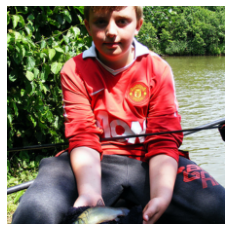

In [35]:
i = 2
#plt.figure(figsize=(5, 5))
plt.imshow(or_images[i])
plt.axis('off')
z = xlabel("Original image")
print("GT: {}\nT1: {}\nT2:{}\n".format(imnet_id_to_name[target[i].item()], imnet_id_to_name[pred_td1[i][0].item()], imnet_id_to_name[pred_td2[i][0].item()]))

### T1 out

(-0.5, 223.5, 223.5, -0.5)

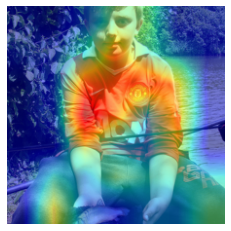

In [36]:
plt.imshow(or_images[i])
#cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
plt.imshow(cv2.resize(maps_layer4_mod4_t1[i], (224,224)), alpha=0.5, cmap='jet');
plt.axis('off')
#z = xlabel(imnet_id_to_name[pred_td1[i][0].item()] + " (t=1; TD3_Resnet50)")

## T2 out

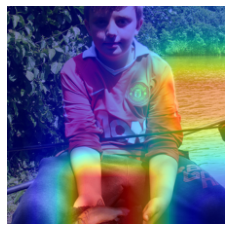

In [37]:
plt.imshow(or_images[i])
#cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
plt.axis('off')
plt.imshow(cv2.resize(maps_layer4_mod4_t2[i], (224,224)), alpha=0.5, cmap='jet');
#z = xlabel(imnet_id_to_name[pred_td2[i][0].item()] + " (t=1; TD3_Resnet50)")

### Original image

GT: tench.n.01
T1: miniskirt.n.01
T2:tench.n.01



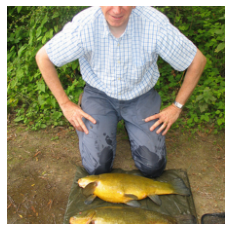

In [38]:
i = 43
#plt.figure(figsize=(5, 5))
plt.imshow(or_images[i])
plt.axis('off')
z = xlabel("Original image")
print("GT: {}\nT1: {}\nT2:{}\n".format(imnet_id_to_name[target[i].item()], imnet_id_to_name[pred_td1[i][0].item()], imnet_id_to_name[pred_td2[i][0].item()]))

### T1 out

(-0.5, 223.5, 223.5, -0.5)

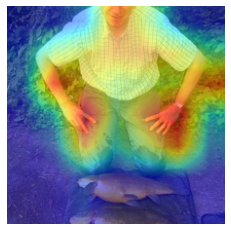

In [39]:
plt.imshow(or_images[i])
#cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
plt.imshow(cv2.resize(maps_layer4_mod4_t1[i], (224,224)), alpha=0.5, cmap='jet');
plt.axis('off')
#z = xlabel(imnet_id_to_name[pred_td1[i][0].item()] + " (t=1; TD3_Resnet50)")

## T2 out

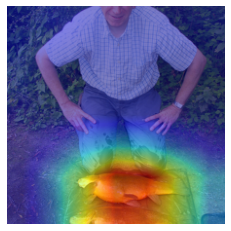

In [40]:
plt.imshow(or_images[i])
#cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
plt.axis('off')
plt.imshow(cv2.resize(maps_layer4_mod4_t2[i], (224,224)), alpha=0.5, cmap='jet');
#z = xlabel(imnet_id_to_name[pred_td2[i][0].item()] + " (t=1; TD3_Resnet50)")

### Original image

GT: horizontal_bar.n.01
T1: plunger.n.03
T2:bow.n.04



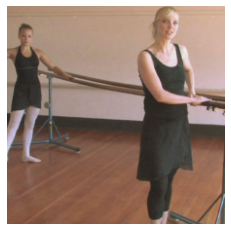

In [45]:
i = 0
#plt.figure(figsize=(5, 5))
plt.imshow(or_images[i])
plt.axis('off')
z = xlabel("Original image")
print("GT: {}\nT1: {}\nT2:{}\n".format(imnet_id_to_name[target[i].item()], imnet_id_to_name[pred_td1[i][0].item()], imnet_id_to_name[pred_td2[i][0].item()]))

### T1 out

(-0.5, 223.5, 223.5, -0.5)

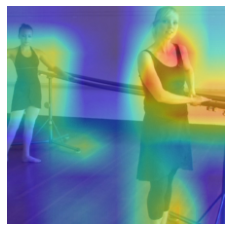

In [46]:
plt.imshow(or_images[i])
#cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
plt.imshow(cv2.resize(maps_layer4_mod4_t1[i], (224,224)), alpha=0.5, cmap='jet');
plt.axis('off')
#z = xlabel(imnet_id_to_name[pred_td1[i][0].item()] + " (t=1; TD3_Resnet50)")

## T2 out

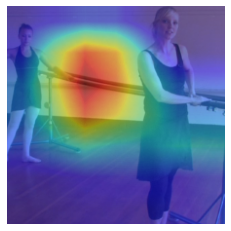

In [47]:
plt.imshow(or_images[i])
#cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
plt.axis('off')
plt.imshow(cv2.resize(maps_layer4_mod4_t2[i], (224,224)), alpha=0.5, cmap='jet');
#z = xlabel(imnet_id_to_name[pred_td2[i][0].item()] + " (t=1; TD3_Resnet50)")

### Original image

GT: hand-held_computer.n.01
T1: hand-held_computer.n.01
T2:hand-held_computer.n.01



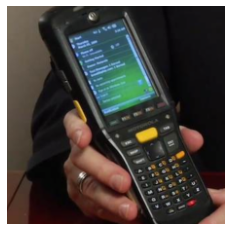

In [48]:
i = 23
#plt.figure(figsize=(5, 5))
plt.imshow(or_images[i])
plt.axis('off')
z = xlabel("Original image")
print("GT: {}\nT1: {}\nT2:{}\n".format(imnet_id_to_name[target[i].item()], imnet_id_to_name[pred_td1[i][0].item()], imnet_id_to_name[pred_td2[i][0].item()]))

### T1 out

(-0.5, 223.5, 223.5, -0.5)

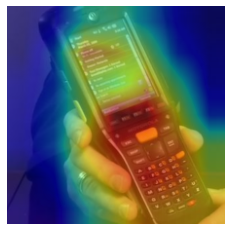

In [49]:
plt.imshow(or_images[i])
#cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
plt.imshow(cv2.resize(maps_layer4_mod4_t1[i], (224,224)), alpha=0.5, cmap='jet');
plt.axis('off')
#z = xlabel(imnet_id_to_name[pred_td1[i][0].item()] + " (t=1; TD3_Resnet50)")

## T2 out

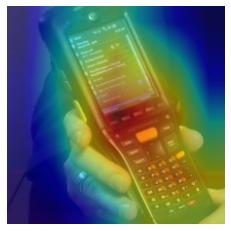

In [50]:
plt.imshow(or_images[i])
#cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
plt.axis('off')
plt.imshow(cv2.resize(maps_layer4_mod4_t2[i], (224,224)), alpha=0.5, cmap='jet');
#z = xlabel(imnet_id_to_name[pred_td2[i][0].item()] + " (t=1; TD3_Resnet50)")

### Original image

GT: ostrich.n.02
T1: ostrich.n.02
T2:ostrich.n.02



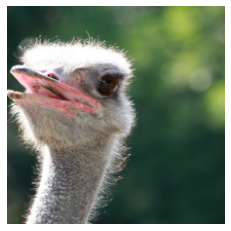

In [53]:
i = 4
#plt.figure(figsize=(5, 5))
plt.imshow(or_images[i])
plt.axis('off')
z = xlabel("Original image")
print("GT: {}\nT1: {}\nT2:{}\n".format(imnet_id_to_name[target[i].item()], imnet_id_to_name[pred_td1[i][0].item()], imnet_id_to_name[pred_td2[i][0].item()]))

### T1 out

(-0.5, 223.5, 223.5, -0.5)

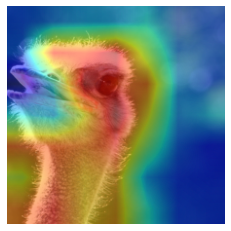

In [54]:
plt.imshow(or_images[i])
#cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
plt.imshow(cv2.resize(maps_layer4_mod4_t1[i], (224,224)), alpha=0.5, cmap='jet');
plt.axis('off')
#z = xlabel(imnet_id_to_name[pred_td1[i][0].item()] + " (t=1; TD3_Resnet50)")

## T2 out

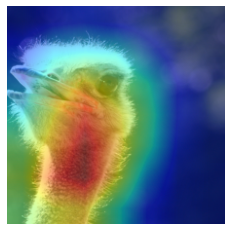

In [55]:
plt.imshow(or_images[i])
#cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
plt.axis('off')
plt.imshow(cv2.resize(maps_layer4_mod4_t2[i], (224,224)), alpha=0.5, cmap='jet');
#z = xlabel(imnet_id_to_name[pred_td2[i][0].item()] + " (t=1; TD3_Resnet50)")